# Tutorial 1: Linear regression

## Load packages

In [ ]:
# Install rpy2 to use R code in Colab notebook
!pip3 install rpy2 
%load_ext rpy2.ipython

In [ ]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load("tidyverse",
               "brms", 
               "dagitty",
               "dplyr",
               "ggplot2",
               "GGally",
               "ggpubr",
               "ggrepel",
               "ggsci",
               "ggthemes",
               "grid",
               "gridExtra",
               "bayesplot",
               "loo",
               "lubridate",
               "MASS",
               "modelr",
               "posterior",
               "psych",
               "rcompanion",
               "hues",
               "RColorBrewer",
               "scales",
               "tidybayes")

# Let us analyze the data and re-create the graphic from The Economist article:
## "[Corrosive corruption: A correlation between corruption and development](https://www.economist.com/graphic-detail/2011/12/02/corrosive-corruption)"

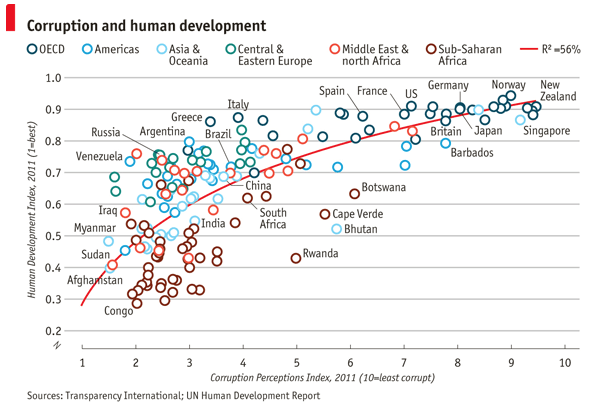

## Read data

In [3]:
%%R
# SOURCES:
# https://www.economist.com/graphic-detail/2011/12/02/corrosive-corruption
# https://databeauty.com/blog/tutorial/2017/03/03/recreate-economist-graph-by-ggplot2.html
# http://rstudio-pubs-static.s3.amazonaws.com/284329_c7e660636fec4a42a09eed968dc47f32.html
# https://readr.tidyverse.org/index.html

# EconomistData <- read_csv("/content/EconomistData.csv")
EconomistData   <- read_csv("https://raw.githubusercontent.com/cbrownley/VIS2022/main/data/EconomistData.csv")
EconomistData

New names:
• `` -> `...1`
Rows: 173 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Country, Region
dbl (4): ...1, HDI.Rank, HDI, CPI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 173 × 6
    ...1 Country     HDI.Rank   HDI   CPI Region           
   <dbl> <chr>          <dbl> <dbl> <dbl> <chr>            
 1     1 Afghanistan      172 0.398   1.5 Asia Pacific     
 2     2 Albania           70 0.739   3.1 East EU Cemt Asia
 3     3 Algeria           96 0.698   2.9 MENA             
 4     4 Angola           148 0.486   2   SSA              
 5     5 Argentina         45 0.797   3   Americas         
 6     6 Armenia           86 0.716   2.6 East EU Cemt Asia
 7     7 Australia          2 0.929   8.8 Asia Pacific     
 8     8 Austria           19 0.885   7.8 EU W. Europe     
 9     9 Azerbaijan    

In [4]:
%%R
# SOURCE: https://dplyr.tidyverse.org/reference/glimpse.html
glimpse(EconomistData)

Rows: 173
Columns: 6
$ ...1     <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…
$ Country  <chr> "Afghanistan", "Albania", "Algeria", "Angola", "Argentina", "…
$ HDI.Rank <dbl> 172, 70, 96, 148, 45, 86, 2, 19, 91, 53, 42, 146, 47, 65, 18,…
$ HDI      <dbl> 0.398, 0.739, 0.698, 0.486, 0.797, 0.716, 0.929, 0.885, 0.700…
$ CPI      <dbl> 1.5, 3.1, 2.9, 2.0, 3.0, 2.6, 8.8, 7.8, 2.4, 7.3, 5.1, 2.7, 7…
$ Region   <chr> "Asia Pacific", "East EU Cemt Asia", "MENA", "SSA", "Americas…


In [5]:
%%R
head(EconomistData, 10)

# A tibble: 10 × 6
    ...1 Country     HDI.Rank   HDI   CPI Region           
   <dbl> <chr>          <dbl> <dbl> <dbl> <chr>            
 1     1 Afghanistan      172 0.398   1.5 Asia Pacific     
 2     2 Albania           70 0.739   3.1 East EU Cemt Asia
 3     3 Algeria           96 0.698   2.9 MENA             
 4     4 Angola           148 0.486   2   SSA              
 5     5 Argentina         45 0.797   3   Americas         
 6     6 Armenia           86 0.716   2.6 East EU Cemt Asia
 7     7 Australia          2 0.929   8.8 Asia Pacific     
 8     8 Austria           19 0.885   7.8 EU W. Europe     
 9     9 Azerbaijan        91 0.7     2.4 East EU Cemt Asia
10    10 Bahamas           53 0.771   7.3 Americas         


## Check for missing values

In [6]:
%%R
sum(is.na(EconomistData))

[1] 0


## Convert `Region` into a factor

In [7]:
%%R
# SOURCE: https://r4ds.had.co.nz/factors.html
EconomistData$Region <- factor(EconomistData$Region,
                               levels = c("EU W. Europe",
                                          "Americas",
                                          "Asia Pacific",
                                          "East EU Cemt Asia",
                                          "MENA",
                                          "SSA"),
                               labels = c("OECD",
                                          "Americas",
                                          "Asia &\nOceania",
                                          "Central &\nEastern Europe",
                                          "Middle East &\nnorth Africa",
                                          "Sub-Saharan\nAfrica"))

In [8]:
%%R
head(EconomistData, 10)

# A tibble: 10 × 6
    ...1 Country     HDI.Rank   HDI   CPI Region                       
   <dbl> <chr>          <dbl> <dbl> <dbl> <fct>                        
 1     1 Afghanistan      172 0.398   1.5 "Asia &\nOceania"            
 2     2 Albania           70 0.739   3.1 "Central &\nEastern Europe"  
 3     3 Algeria           96 0.698   2.9 "Middle East &\nnorth Africa"
 4     4 Angola           148 0.486   2   "Sub-Saharan\nAfrica"        
 5     5 Argentina         45 0.797   3   "Americas"                   
 6     6 Armenia           86 0.716   2.6 "Central &\nEastern Europe"  
 7     7 Australia          2 0.929   8.8 "Asia &\nOceania"            
 8     8 Austria           19 0.885   7.8 "OECD"                       
 9     9 Azerbaijan        91 0.7     2.4 "Central &\nEastern Europe"  
10    10 Bahamas           53 0.771   7.3 "Americas"                   


## Exploratory Data Analysis (EDA)

#### Average Human Development Index (`HDI`) and Corruption Perceptions Index (`CPI`) by `Region`

In [9]:
%%R
# SOURCE: https://r4ds.had.co.nz/transform.html#grouped-summaries-with-summarise
EconomistData %>%
  group_by(Region) %>%
  summarize(Mean_HDI = mean(HDI, na.rm = TRUE),
            Mean_CPI = mean(CPI, na.rm = TRUE))

# A tibble: 6 × 3
  Region                        Mean_HDI Mean_CPI
  <fct>                            <dbl>    <dbl>
1 "OECD"                           0.861     6.51
2 "Americas"                       0.720     4.17
3 "Asia &\nOceania"                0.645     3.97
4 "Central &\nEastern Europe"      0.713     2.84
5 "Middle East &\nnorth Africa"    0.711     3.88
6 "Sub-Saharan\nAfrica"            0.450     2.96


## View relationship between Human Development Index (HDI) and Corruption Perceptions Index (CPI)

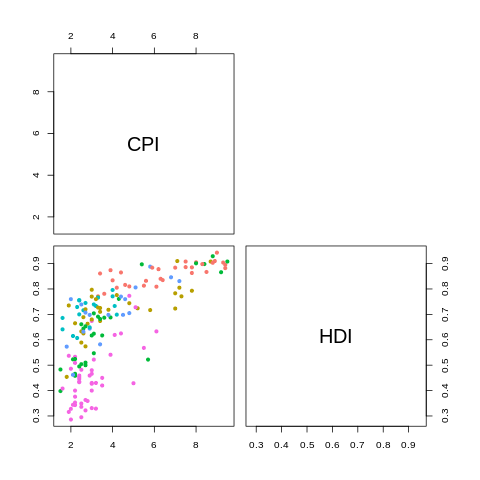

In [10]:
#@title Pairs plot of HDI and CPI (version 1)
%%R
# SOURCES: 
# http://www.sthda.com/english/wiki/scatter-plot-matrices-r-base-graphs
# https://scales.r-lib.org/reference/hue_pal.html
pairs(EconomistData[,c("CPI", "HDI")], 
      pch = 19, 
      cex = 0.75, 
      col = scales::hue_pal()(6)[EconomistData$Region], 
      upper.panel=NULL)

In [31]:
%%R
bind_cols(unique(EconomistData$Region), unique(scales::hue_pal()(6)[EconomistData$Region]))

New names:
• `` -> `...1`
• `` -> `...2`
# A tibble: 6 × 2
  ...1                          ...2   
  <fct>                         <chr>  
1 "Asia &\nOceania"             #00BA38
2 "Central &\nEastern Europe"   #00BFC4
3 "Middle East &\nnorth Africa" #619CFF
4 "Sub-Saharan\nAfrica"         #F564E3
5 "Americas"                    #B79F00
6 "OECD"                        #F8766D


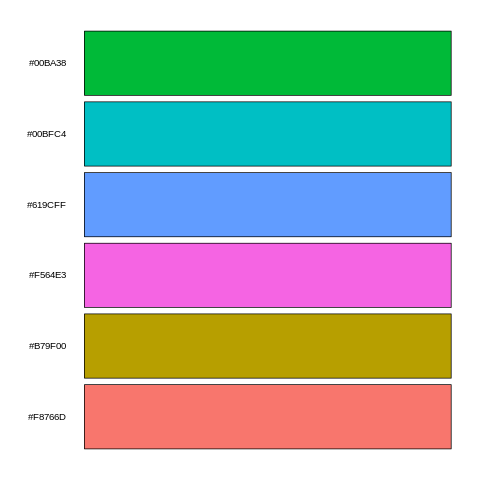

In [34]:
%%R
hues::swatch(unique(scales::hue_pal()(6)[EconomistData$Region]))

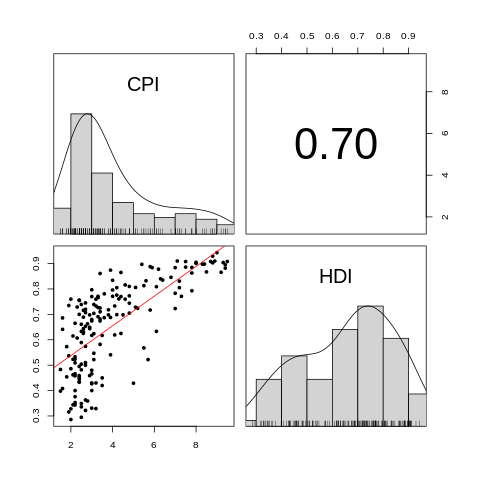

In [11]:
#@title Pairs plot of HDI and CPI (version 2)
%%R
# SOURCE: https://www.rdocumentation.org/packages/psych/versions/2.2.5/topics/pairs.panels
psych::pairs.panels(EconomistData[,c("CPI", "HDI")], 
                    method = "pearson", 
                    hist.col = "lightgrey", # "#00AFBB", 
                    lm = TRUE,
                    density = TRUE, 
                    ellipses = FALSE)

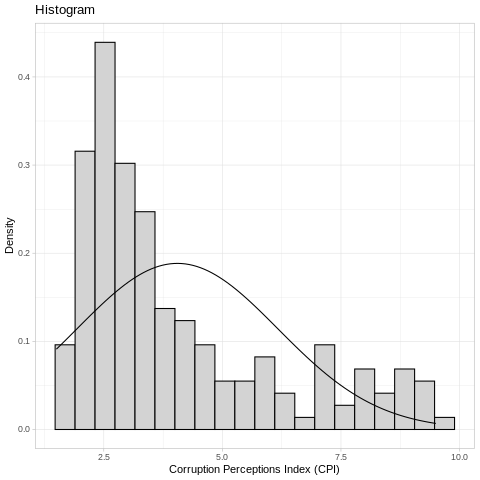

In [12]:
#@title Histogram of CPI
%%R
# SOURCE: https://www.statology.org/overlay-normal-curve-histogram-in-r/
p1 <- ggplot(EconomistData, aes(x = CPI)) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(EconomistData$CPI), sd=sd(EconomistData$CPI))) +
  scale_y_continuous(labels = number_format(accuracy = 0.1)) +
  labs(title = "Histogram",
       y = "Density", 
       x = "Corruption Perceptions Index (CPI)") + 
  theme_light()
p1

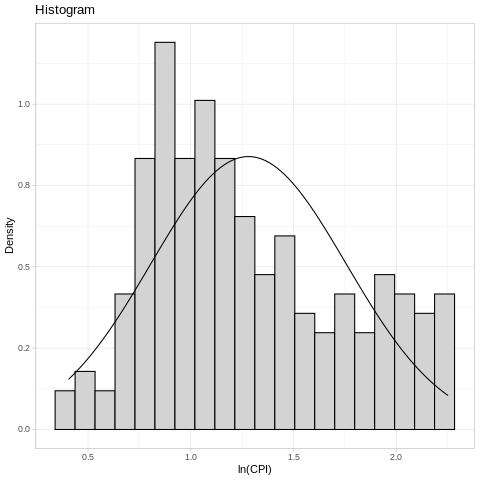

In [13]:
#@title Histogram of log(CPI)
%%R
# SOURCE: https://www.statology.org/overlay-normal-curve-histogram-in-r/
p1 <- ggplot(EconomistData, aes(x = log(CPI))) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(log(EconomistData$CPI)), sd=sd(log(EconomistData$CPI)))) +
  scale_y_continuous(labels = number_format(accuracy = 0.1)) +
  labs(title = "Histogram",
       y = "Density", 
       x = "ln(CPI)") + 
  theme_light()
p1

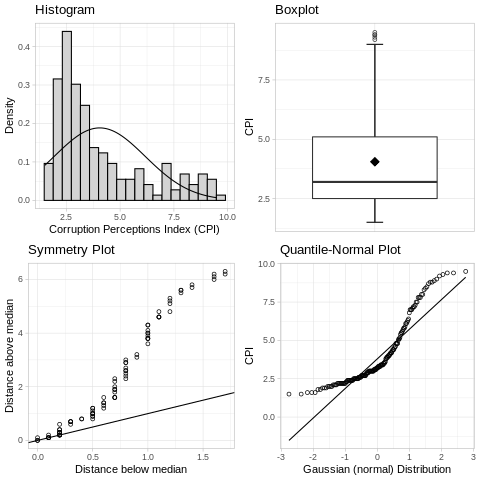

In [14]:
#@title Histogram, Boxplot, Symmetry plot, and Quantile-Normal plot of CPI
%%R
# Histogram
# https://www.statology.org/overlay-normal-curve-histogram-in-r/
p1 <- ggplot(EconomistData, aes(x = CPI)) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(EconomistData$CPI), sd=sd(EconomistData$CPI))) +
  scale_y_continuous(labels = number_format(accuracy = 0.1)) +
  labs(title = "Histogram",
       y = "Density", 
       x = "Corruption Perceptions Index (CPI)") + 
  theme_light()
p1

# Boxplot
p2 <- ggplot(EconomistData, aes(x=factor(0), y = CPI)) +
  stat_boxplot(geom = "errorbar",
               width = 0.10) + 
  geom_boxplot(outlier.shape = 1) +
  stat_summary(fun = "mean", geom = "point", shape = 23, size = 3, fill = "black") +
  labs(title = "Boxplot",
       y = "CPI", 
       x = NULL) + 
  theme_light() +
  theme(axis.title.x=element_blank(), 
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank())
p2
  
# Symmetry Plot
# LearnEDAfunctions::symplot(x)
# https://rdrr.io/github/bayesball/LearnEDAfunctions/src/R/symplot.R
symdat <- function(d){
  n <- length(d)
  no <- floor((n + 1) / 2)
  sd <- sort(d)
  i <- 1 : no
  u <- sd[n + 1 - i] - median(d)
  v <- median(d) - sd[i]
  return(list("v"=v, "u"=u))
}

dat <- as.data.frame(symdat(EconomistData$CPI))

p3 <- ggplot(dat, aes(v, u)) + 
  geom_point(shape=1) + 
  geom_abline() +
  labs(title = "Symmetry Plot",
       y="Distance above median",
       x="Distance below median") + 
  theme_light()
p3

# Quantile-Normal Plot
p4 <- ggplot(EconomistData, aes(sample = CPI)) + 
  stat_qq(shape=1) + 
  stat_qq_line() +
  labs(title = "Quantile-Normal Plot",
       y="CPI",
       x="Gaussian (normal) Distribution") + 
  theme_light()
p4

# https://cran.r-project.org/web/packages/egg/vignettes/Ecosystem.html
# https://cran.r-project.org/web/packages/egg/vignettes/Overview.html
grid.arrange(p1, p2, p3, p4, nrow = 2, ncol = 2)

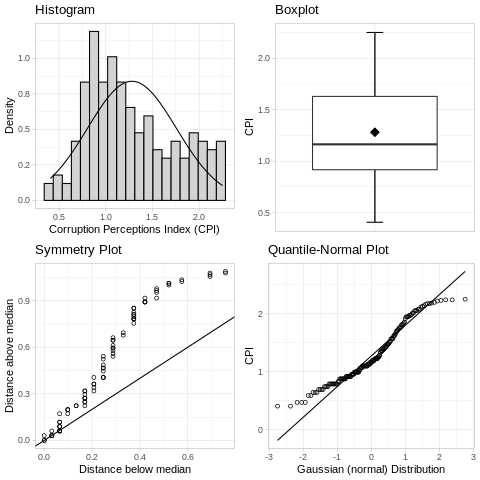

In [15]:
#@title Histogram, Boxplot, Symmetry plot, and Quantile-Normal plot of log(CPI)
%%R
# Histogram
# https://www.statology.org/overlay-normal-curve-histogram-in-r/
p1 <- ggplot(EconomistData, aes(x = log(CPI))) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(log(EconomistData$CPI)), sd=sd(log(EconomistData$CPI)))) +
  scale_y_continuous(labels = number_format(accuracy = 0.1)) +
  labs(title = "Histogram",
       y = "Density", 
       x = "Corruption Perceptions Index (CPI)") + 
  theme_light()
p1

# Boxplot
p2 <- ggplot(EconomistData, aes(x=factor(0), y = log(CPI))) +
  stat_boxplot(geom = "errorbar",
               width = 0.10) + 
  geom_boxplot(outlier.shape = 1) +
  stat_summary(fun = "mean", geom = "point", shape = 23, size = 3, fill = "black") +
  labs(title = "Boxplot",
       y = "CPI", 
       x = NULL) + 
  theme_light() +
  theme(axis.title.x=element_blank(), 
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank())
p2
  
# Symmetry Plot
# LearnEDAfunctions::symplot(x)
# https://rdrr.io/github/bayesball/LearnEDAfunctions/src/R/symplot.R
symdat <- function(d){
  n <- length(d)
  no <- floor((n + 1) / 2)
  sd <- sort(d)
  i <- 1 : no
  u <- sd[n + 1 - i] - median(d)
  v <- median(d) - sd[i]
  return(list("v"=v, "u"=u))
}

dat <- as.data.frame(symdat(log(EconomistData$CPI)))

p3 <- ggplot(dat, aes(v, u)) + 
  geom_point(shape=1) + 
  geom_abline() +
  labs(title = "Symmetry Plot",
       y="Distance above median",
       x="Distance below median") + 
  theme_light()
p3

# Quantile-Normal Plot
p4 <- ggplot(EconomistData, aes(sample = log(CPI))) + 
  stat_qq(shape=1) + 
  stat_qq_line() +
  labs(title = "Quantile-Normal Plot",
       y="CPI",
       x="Gaussian (normal) Distribution") + 
  theme_light()
p4

# https://cran.r-project.org/web/packages/egg/vignettes/Ecosystem.html
# https://cran.r-project.org/web/packages/egg/vignettes/Overview.html
grid.arrange(p1, p2, p3, p4, nrow = 2, ncol = 2)

## Plot relationship between Human Development Index (HDI) and Corruption Perceptions Index (CPI)

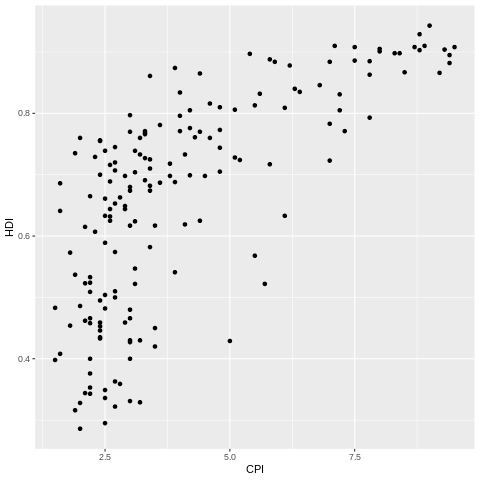

In [16]:
%%R
g1 <-  ggplot(EconomistData, aes(y = HDI, x = CPI))

g1 + geom_point()

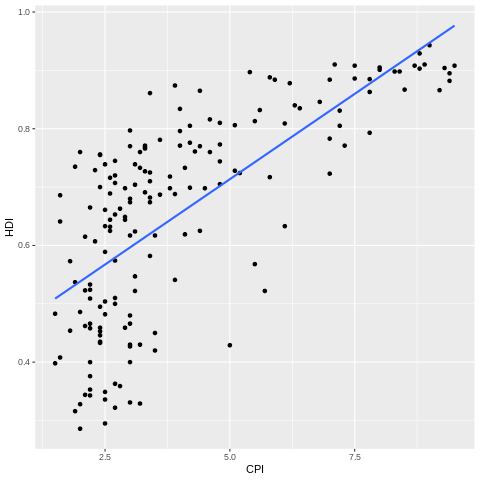

In [22]:
%%R
g1 <-  ggplot(EconomistData, aes(y = HDI, x = CPI))

g1 + 
  geom_point() +
  geom_smooth(formula = y ~ x, method = lm, se = FALSE)

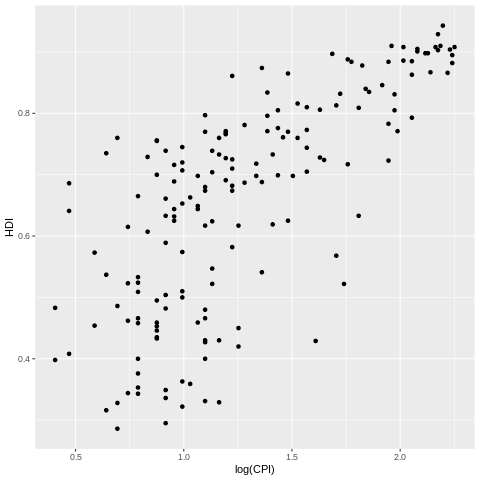

In [18]:
%%R
# log(CPI)
g1 <-  ggplot(EconomistData, aes(y = HDI, x = log(CPI)))

g1 + geom_point()

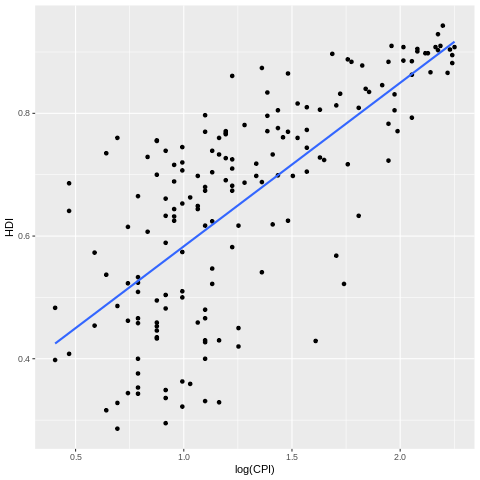

In [23]:
%%R
# y ~ log(x)
g1 <-  ggplot(EconomistData, aes(y = HDI, x = log(CPI))) # CPI

g1 + 
  geom_point() +
  geom_smooth(formula = y ~ x, method = lm, se = FALSE) # y ~ log(x)

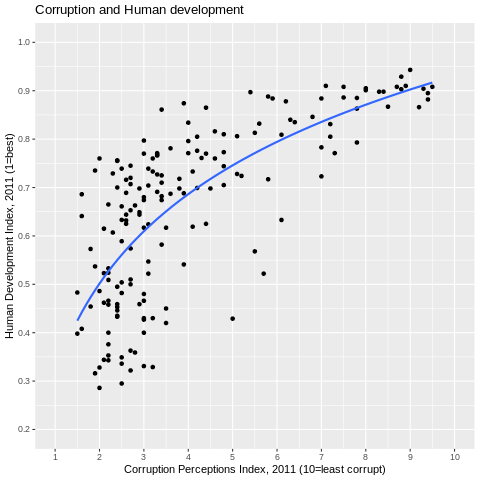

In [24]:
%%R
g1 <-  ggplot(EconomistData, aes(y = HDI, x = CPI))

g1 + 
  geom_point() +
  geom_smooth(formula = y ~ log(x), method = lm, se = FALSE) +
  scale_x_continuous(name = "Corruption Perceptions Index, 2011 (10=least corrupt)",
                     limits = c(1.0, 10.0),
                     breaks = 1:10) +
  scale_y_continuous(name = "Human Development Index, 2011 (1=best)",
                     limits = c(0.2, 1.0),
                     breaks = seq(0.2, 1.0, by = 0.1)) +
  ggtitle("Corruption and Human development")

## Prior predictive simulation

In [27]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#the-linear-model-strategy.
set.seed(2971)

n_lines <- 100

lines <-
  tibble(n = 1:n_lines,
         a = rnorm(n_lines, mean = 0.5, sd = 0.2),
         b = rnorm(n_lines, mean = 0, sd = 1)) %>% # standard deviation: 1
  expand(nesting(n, a, b), CPI = range(EconomistData$CPI)) %>% 
  mutate(HDI = a + b * (CPI - mean(EconomistData$CPI)))

head(lines)

# A tibble: 6 × 5
      n     a       b   CPI    HDI
  <int> <dbl>   <dbl> <dbl>  <dbl>
1     1 0.626 -0.706    1.5  2.43 
2     1 0.626 -0.706    9.5 -3.22 
3     2 0.712  0.0839   1.5  0.497
4     2 0.712  0.0839   9.5  1.17 
5     3 0.736  0.393    1.5 -0.266
6     3 0.736  0.393    9.5  2.88 


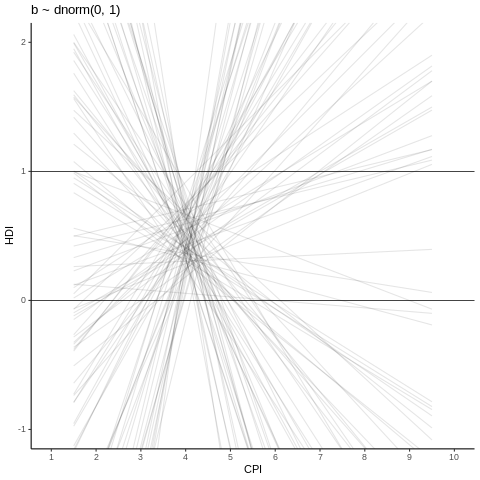

In [28]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#the-linear-model-strategy.
lines %>% 
  ggplot(aes(x = CPI, y = HDI, group = n)) +
  geom_hline(yintercept = c(0, 1), linetype = 1:1, size = 1/3) +
  geom_line(alpha = 1/10) +
  coord_cartesian(ylim = c(-1, 2)) +
  scale_x_continuous(limits = c(1.0, 10.0), 
                     breaks = 1:10) +
  ggtitle("b ~ dnorm(0, 1)") +
  theme_classic()

In [29]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#the-linear-model-strategy.
set.seed(2971)

n_lines <- 100

lines <-
  tibble(n = 1:n_lines,
         a = rnorm(n_lines, mean = 0.5, sd = 0.2),
         b = rnorm(n_lines, mean = 0, sd = 0.1)) %>% # standard deviation: 0.1
  expand(nesting(n, a, b), CPI = range(EconomistData$CPI)) %>% 
  mutate(HDI = a + b * (CPI - mean(EconomistData$CPI)))

head(lines)

# A tibble: 6 × 5
      n     a        b   CPI   HDI
  <int> <dbl>    <dbl> <dbl> <dbl>
1     1 0.626 -0.0706    1.5 0.806
2     1 0.626 -0.0706    9.5 0.242
3     2 0.712  0.00839   1.5 0.690
4     2 0.712  0.00839   9.5 0.757
5     3 0.736  0.0393    1.5 0.636
6     3 0.736  0.0393    9.5 0.950


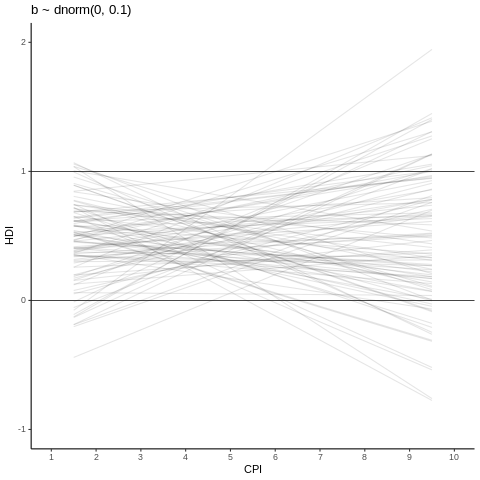

In [30]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#the-linear-model-strategy.
lines %>% 
  ggplot(aes(x = CPI, y = HDI, group = n)) +
  geom_hline(yintercept = c(0, 1), linetype = 1:1, size = 1/3) +
  geom_line(alpha = 1/10) +
  coord_cartesian(ylim = c(-1, 2)) +
  scale_x_continuous(limits = c(1.0, 10.0), 
                     breaks = 1:10) +
  ggtitle("b ~ dnorm(0, 0.1)") +
  theme_classic()

## Fit a model

In [ ]:
%%R
EconomistData <- 
  EconomistData %>% 
    mutate(CPI_c = CPI - mean(CPI))

head(EconomistData)

# A tibble: 6 × 7
   ...1 Country     HDI.Rank   HDI   CPI Region                         CPI_c
  <dbl> <chr>          <dbl> <dbl> <dbl> <fct>                          <dbl>
1     1 Afghanistan      172 0.398   1.5 "Asia &\nOceania"             -2.55 
2     2 Albania           70 0.739   3.1 "Central &\nEastern Europe"   -0.952
3     3 Algeria           96 0.698   2.9 "Middle East &\nnorth Africa" -1.15 
4     4 Angola           148 0.486   2   "Sub-Saharan\nAfrica"         -2.05 
5     5 Argentina         45 0.797   3   "Americas"                    -1.05 
6     6 Armenia           86 0.716   2.6 "Central &\nEastern Europe"   -1.45 


In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#finding-the-posterior-distribution.
b1 <- 
  brm(data = EconomistData, 
      family = gaussian,
      HDI ~ 1 + CPI_c,
      prior = c(prior(normal(0.5, 0.2), class = Intercept),
                prior(normal(0, 0.1), class = b),
                prior(uniform(0, 1), class = sigma)),
      chains = 4, cores = 4, seed = 4)

In [ ]:
%%R
print(b1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: HDI ~ 1 + CPI_c 
   Data: EconomistData (Number of observations: 173) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.66      0.01     0.64     0.68 1.00     4093     2852
CPI_c         0.06      0.00     0.05     0.07 1.00     5162     3117

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.13      0.01     0.11     0.14 1.00     3140     2498

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


## Check MCMC diagnostics

In [ ]:
%%R
# SOURCE: http://paul-buerkner.github.io/brms/reference/posterior_samples.html
post1 <- posterior_samples(b1, add_chain = T)
head(post1)

  b_Intercept    b_CPI_c     sigma   lprior     lp__ chain iter
1   0.6522150 0.05372157 0.1298468 1.640228 113.9639     1 1001
2   0.6680635 0.06161175 0.1224048 1.531279 113.9560     1 1002
3   0.6526517 0.05600133 0.1221972 1.626057 114.5402     1 1003
4   0.6657458 0.06069355 0.1259853 1.546565 114.3903     1 1004
5   0.6527751 0.05547168 0.1210110 1.628538 114.3855     1 1005
6   0.6618052 0.06124959 0.1230210 1.559309 114.5629     1 1006


In [ ]:
%%R
str(post1)

'data.frame':	4000 obs. of  7 variables:
 $ b_Intercept: num  0.652 0.668 0.653 0.666 0.653 ...
 $ b_CPI_c    : num  0.0537 0.0616 0.056 0.0607 0.0555 ...
 $ sigma      : num  0.13 0.122 0.122 0.126 0.121 ...
 $ lprior     : num  1.64 1.53 1.63 1.55 1.63 ...
 $ lp__       : num  114 114 115 114 114 ...
 $ chain      : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ iter       : num  1001 1002 1003 1004 1005 ...


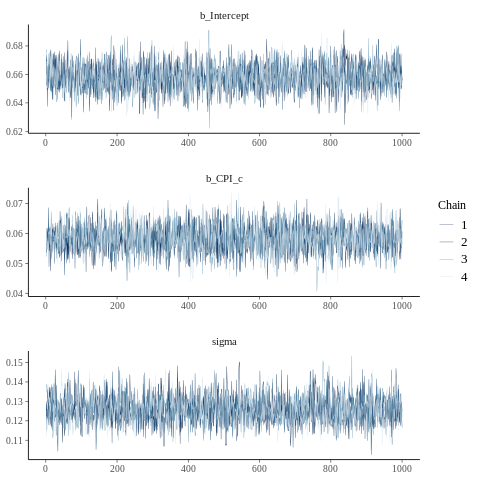

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/markov-chain-monte-carlo.html#visualization.
mcmc_trace(post1[,c(1:3,6)],
           facet_args = list(nrow = 3), 
           size = .15)

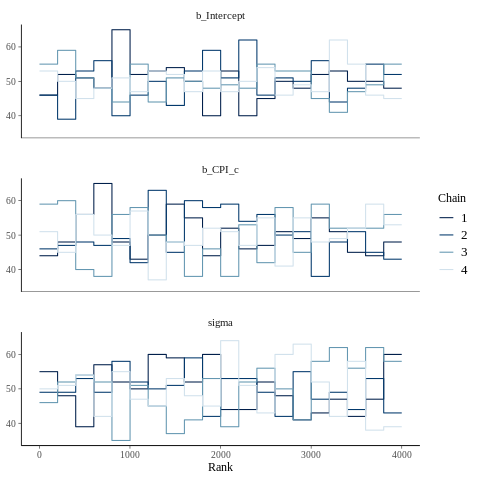

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/markov-chain-monte-carlo.html#visualization.
post1 %>% 
  mcmc_rank_overlay(pars = vars(b_Intercept:sigma),
                    facet_args = list(nrow = 3)) +
  coord_cartesian(ylim = c(35, NA))

## Residual and PSIS Pareto k plots

In [ ]:
%%R
# SOURCE: https://mc-stan.org/loo/articles/loo2-example.html
loo(b1)


Computed from 4000 by 173 log-likelihood matrix

         Estimate   SE
elpd_loo    112.7  7.6
p_loo         2.2  0.2
looic      -225.4 15.2
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.


In [ ]:
%%R
# Pareto smoothed importance-sampling leave-one-out cross-validation (PSIS-LOO)
b1 <- add_criterion(b1, criterion = "loo")

In [ ]:
%%R
# Widely applicable information criterion (WAIC)
b1 <- add_criterion(b1, criterion = "waic")

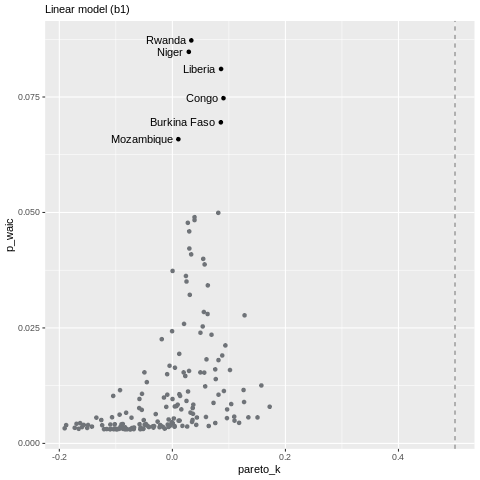

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/ulysses-compass.html#outliers-and-other-illusions.
tibble(pareto_k = b1$criteria$loo$diagnostics$pareto_k,
       p_waic   = b1$criteria$waic$pointwise[, "p_waic"],
       region   = pull(EconomistData, Region),
       country  = pull(EconomistData, Country)) %>% 
  
  ggplot(aes(x = pareto_k, y = p_waic)) + # colour = region
  geom_point(aes(colour = ifelse(p_waic > 0.05, "black", "#6F7378"))) +
  geom_vline(xintercept = .5, linetype = 2, color = "black", alpha = 1/2) +
  geom_text(data = . %>% filter(p_waic > 0.05),
            aes(x = pareto_k - 0.01, label = country),
            hjust = 1) + 
  scale_color_identity() +
  labs(subtitle = "Linear model (b1)") +
  theme(legend.position = "top")

## Residual vs predicted plots

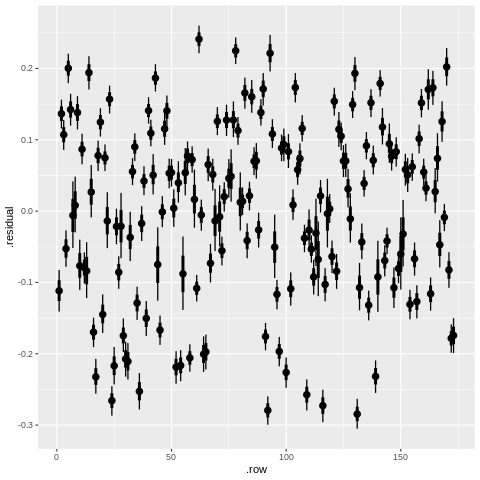

In [ ]:
%%R
# SOURCE: https://mjskay.github.io/tidybayes/articles/tidybayes-residuals.html
EconomistData %>%
  add_residual_draws(b1) %>%
  ggplot(aes(x = .row, y = .residual)) +
  stat_pointinterval()

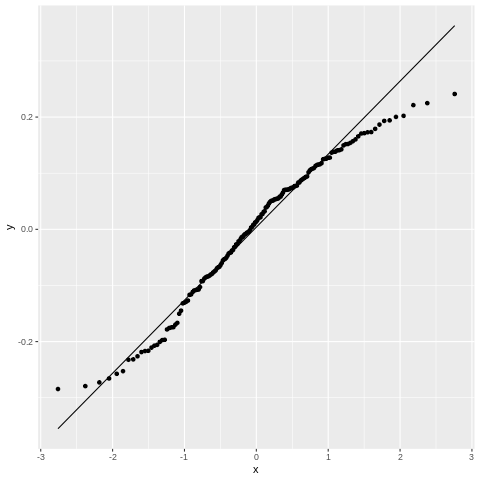

In [ ]:
%%R
# SOURCE: https://mjskay.github.io/tidybayes/articles/tidybayes-residuals.html
EconomistData %>%
  add_residual_draws(b1) %>%
  median_qi() %>%
  ggplot(aes(sample = .residual)) +
  geom_qq() +
  geom_qq_line()

In [ ]:
%%R
# SOURCE: https://avehtari.github.io/ROS-Examples/Introclass/residual_plots.html
predicted <- predict(b1)
head(predicted)

      Estimate  Est.Error      Q2.5     Q97.5
[1,] 0.5093768 0.01506910 0.4805855 0.5387838
[2,] 0.6026024 0.01047974 0.5828394 0.6230084
[3,] 0.5909492 0.01088547 0.5704681 0.6121907
[4,] 0.5385098 0.01336691 0.5130203 0.5640932
[5,] 0.5967758 0.01067452 0.5763992 0.6176668
[6,] 0.5734694 0.01160622 0.5516287 0.5962293


In [ ]:
%%R
# SOURCE: https://avehtari.github.io/ROS-Examples/Introclass/residual_plots.html
resid <- EconomistData$HDI - predicted[,"Estimate"]
str(resid)

 num [1:173] -0.1114 0.1364 0.1071 -0.0525 0.2002 ...


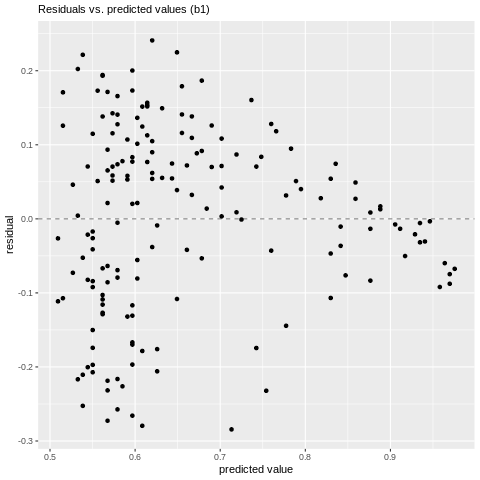

In [ ]:
%%R
# SOURCE: https://avehtari.github.io/ROS-Examples/Introclass/residual_plots.html
tibble(predicted = predicted[,"Estimate"], resid = resid) %>%

  ggplot(aes(x = predicted, y = resid)) +
    geom_point() +
    geom_hline(yintercept = 0, linetype = 2, color = "black", alpha = 1/2) +
    labs(subtitle = "Residuals vs. predicted values (b1)",
        y = "residual",
        x = "predicted value")

## Posterior predictive checks

In [ ]:
%%R
# SOURCE: https://mc-stan.org/bayesplot/articles/graphical-ppcs.html
b1_pp <- posterior_predict(b1, draws = 500)
dim(b1_pp)

[1] 4000  173


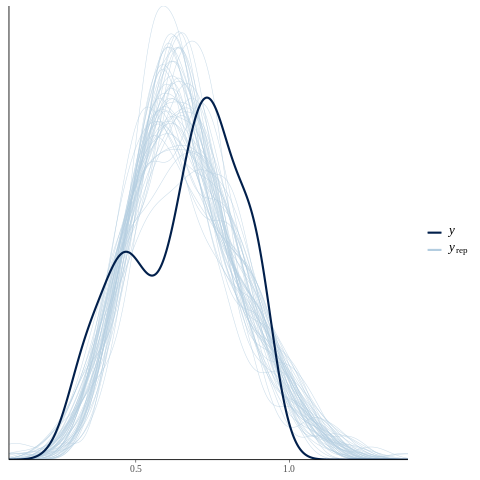

In [ ]:
%%R
# SOURCE: https://mc-stan.org/bayesplot/articles/graphical-ppcs.html
ppc_dens_overlay(EconomistData$HDI, b1_pp[1:50, ])

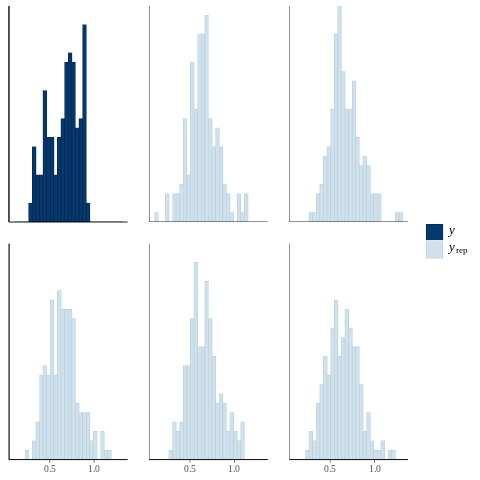

In [ ]:
%%R
# SOURCE: https://mc-stan.org/bayesplot/articles/graphical-ppcs.html
ppc_hist(EconomistData$HDI, b1_pp[1:5, ])

## Posterior parameter estimates

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
posterior_summary(b1)[1:3, ] %>% 
  round(digits = 2)

            Estimate Est.Error Q2.5 Q97.5
b_Intercept     0.66      0.01 0.64  0.68
b_CPI_c         0.06      0.00 0.05  0.07
sigma           0.13      0.01 0.11  0.14


In [ ]:
%%R
# SOURCE: https://mjskay.github.io/tidybayes/articles/tidy-brms.html
b1 %>%
  gather_draws(b_Intercept, b_CPI_c, sigma) %>%
  median_qi()

# A tibble: 3 × 7
  .variable   .value .lower .upper .width .point .interval
  <chr>        <dbl>  <dbl>  <dbl>  <dbl> <chr>  <chr>    
1 b_CPI_c     0.0583 0.0492 0.0673   0.95 median qi       
2 b_Intercept 0.658  0.639  0.676    0.95 median qi       
3 sigma       0.126  0.113  0.140    0.95 median qi       


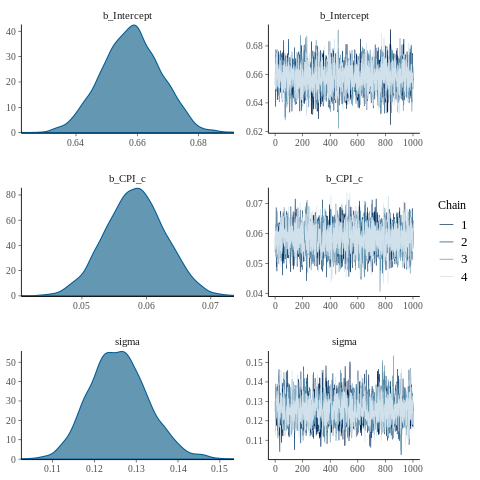

In [ ]:
%%R
plot(b1)

## Plot uncertainty in the estimated coefficients

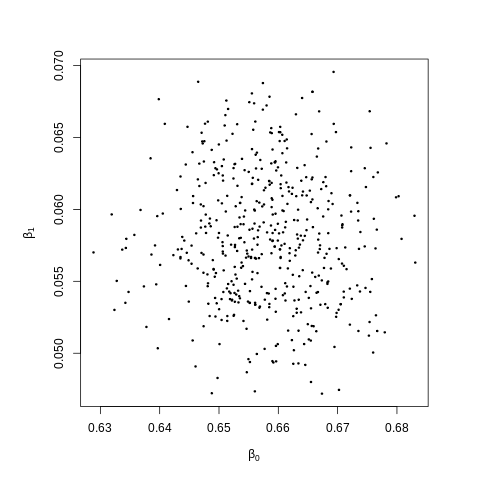

In [ ]:
%%R
sims <- as.matrix(b1)

par(pty="s")
plot(sims[1:500,1], sims[1:500,2], 
     xlab=expression(beta[0]), ylab=expression(beta[1]), 
     pch=20, cex=.5)

## Plot posterior inference and data

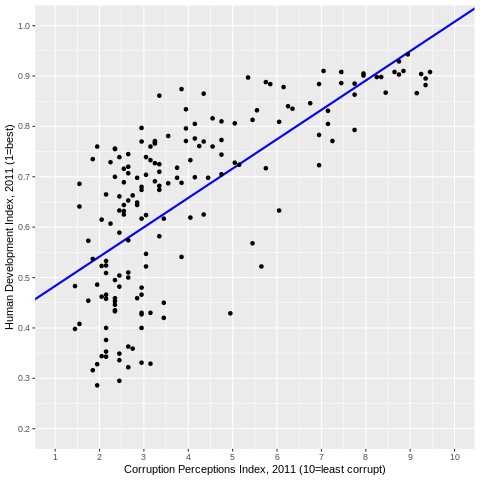

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
labels <- 
  -6:2:6 + mean(EconomistData$CPI) %>% 
  round(digits = 0)

EconomistData %>%
  ggplot(aes(x = CPI_c, y = HDI)) +
  #geom_smooth(formula = y ~ x, method = "lm", se = FALSE) +
  geom_abline(intercept = fixef(b1)[1], 
              slope     = fixef(b1)[2],
              colour = "blue",
              size = 1) +
  geom_point() +
  scale_x_continuous(name = "Corruption Perceptions Index, 2011 (10=least corrupt)",
                     breaks = -6:2:6,
                     limits = c(-3,6), # Extent of CPI_c for extent of CPI (1-10)
                     labels = labels) +
  scale_y_continuous(name = "Human Development Index, 2011 (1=best)",
                     limits = c(0.2, 1.0),
                     breaks = seq(0.2, 1.0, by = 0.1))

## Fit Model 2 (i.e. the model fit in the article)

In [ ]:
%%R
EconomistData <- 
  EconomistData %>% 
    mutate(logCPI = log(CPI))

glimpse(EconomistData)

Rows: 173
Columns: 8
$ ...1     <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…
$ Country  <chr> "Afghanistan", "Albania", "Algeria", "Angola", "Argentina", "…
$ HDI.Rank <dbl> 172, 70, 96, 148, 45, 86, 2, 19, 91, 53, 42, 146, 47, 65, 18,…
$ HDI      <dbl> 0.398, 0.739, 0.698, 0.486, 0.797, 0.716, 0.929, 0.885, 0.700…
$ CPI      <dbl> 1.5, 3.1, 2.9, 2.0, 3.0, 2.6, 8.8, 7.8, 2.4, 7.3, 5.1, 2.7, 7…
$ Region   <fct> Asia &
Oceania, Central &
Eastern Europe, Middle East &
north Af…
$ CPI_c    <dbl> -2.5520231, -0.9520231, -1.1520231, -2.0520231, -1.0520231, -…
$ logCPI   <dbl> 0.4054651, 1.1314021, 1.0647107, 0.6931472, 1.0986123, 0.9555…


In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#finding-the-posterior-distribution.
b2 <- 
  brm(data = EconomistData, 
      family = gaussian,
      HDI ~ 1 + logCPI,
      prior = c(prior(normal(0.5, 0.2), class = Intercept),
                prior(normal(0, 0.1), class = b),
                prior(uniform(0, 1), class = sigma)),
      chains = 4, cores = 4, seed = 4)

In [ ]:
%%R
print(b2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: HDI ~ 1 + logCPI 
   Data: EconomistData (Number of observations: 173) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.33      0.03     0.28     0.38 1.00     3912     3161
logCPI        0.26      0.02     0.22     0.30 1.00     3866     2841

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.12      0.01     0.11     0.14 1.00     3233     2818

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [ ]:
%%R
# SOURCE: http://paul-buerkner.github.io/brms/reference/posterior_samples.html
post2 <- posterior_samples(b2, add_chain = T)
head(post2)

  b_Intercept  b_logCPI     sigma     lprior     lp__ chain iter
1   0.2664476 0.2924737 0.1208208 -2.4513622 112.5058     1 1001
2   0.3955271 0.2215179 0.1259696 -0.7807749 111.6688     1 1002
3   0.3359496 0.2617515 0.1271973 -1.7176833 114.5793     1 1003
4   0.3288917 0.2577295 0.1300347 -1.5628429 115.1720     1 1004
5   0.3609700 0.2400344 0.1278548 -1.1609761 114.5976     1 1005
6   0.3498882 0.2397542 0.1190840 -1.1077371 115.4161     1 1006


In [ ]:
%%R
str(post2)

'data.frame':	4000 obs. of  7 variables:
 $ b_Intercept: num  0.266 0.396 0.336 0.329 0.361 ...
 $ b_logCPI   : num  0.292 0.222 0.262 0.258 0.24 ...
 $ sigma      : num  0.121 0.126 0.127 0.13 0.128 ...
 $ lprior     : num  -2.451 -0.781 -1.718 -1.563 -1.161 ...
 $ lp__       : num  113 112 115 115 115 ...
 $ chain      : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ iter       : num  1001 1002 1003 1004 1005 ...


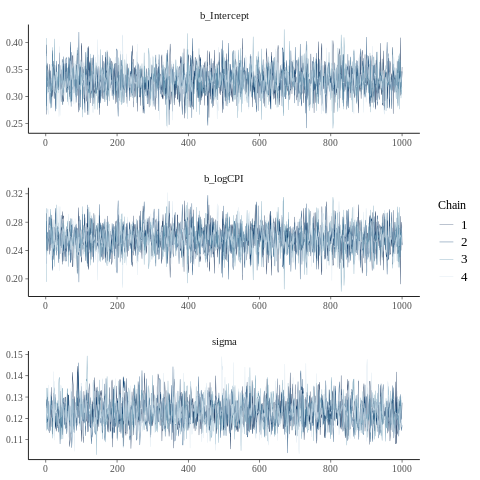

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/markov-chain-monte-carlo.html#visualization.
mcmc_trace(post2[,c(1:3,6)],
           facet_args = list(nrow = 3), 
           size = .15)

In [ ]:
%%R
# Pareto smoothed importance-sampling leave-one-out cross-validation (PSIS-LOO)
b2 <- add_criterion(b2, criterion = "loo")

In [ ]:
%%R
# Widely applicable information criterion (WAIC)
b2 <- add_criterion(b2, criterion = "waic")

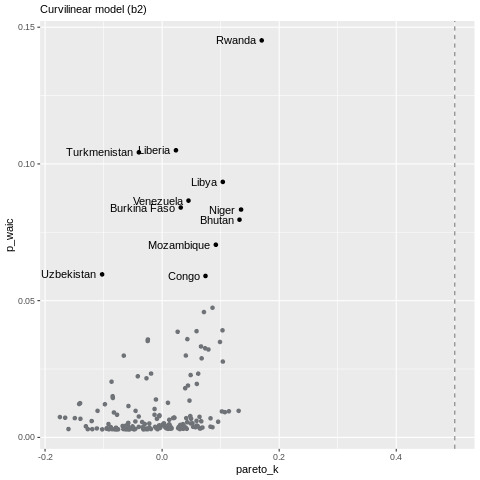

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/ulysses-compass.html#outliers-and-other-illusions.
tibble(pareto_k = b2$criteria$loo$diagnostics$pareto_k,
       p_waic   = b2$criteria$waic$pointwise[, "p_waic"],
       region   = pull(EconomistData, Region),
       country  = pull(EconomistData, Country)) %>% 
  
  ggplot(aes(x = pareto_k, y = p_waic)) + # colour = region
  geom_point(aes(colour = ifelse(p_waic > 0.05, "black", "#6F7378"))) +
  geom_vline(xintercept = .5, linetype = 2, color = "black", alpha = 1/2) +
  geom_text(data = . %>% filter(p_waic > 0.05),
            aes(x = pareto_k - 0.01, label = country),
            hjust = 1) + 
  scale_color_identity() +
  labs(subtitle = "Curvilinear model (b2)") +
  theme(legend.position = "top")

In [ ]:
%%R
# SOURCE: https://avehtari.github.io/ROS-Examples/Introclass/residual_plots.html
predicted2 <- predict(b2)
head(predicted2)

      Estimate Est.Error      Q2.5     Q97.5
[1,] 0.4356361 0.1261103 0.1826396 0.6783577
[2,] 0.6192731 0.1206739 0.3761799 0.8507568
[3,] 0.6024597 0.1228588 0.3648572 0.8414762
[4,] 0.5056225 0.1213564 0.2640881 0.7446288
[5,] 0.6139727 0.1239132 0.3778724 0.8541142
[6,] 0.5770411 0.1209716 0.3326085 0.8100273


In [ ]:
%%R
# SOURCE: https://avehtari.github.io/ROS-Examples/Introclass/residual_plots.html
resid2 <- EconomistData$HDI - predicted2[,"Estimate"]
str(resid2)

 num [1:173] -0.0376 0.1197 0.0955 -0.0196 0.183 ...


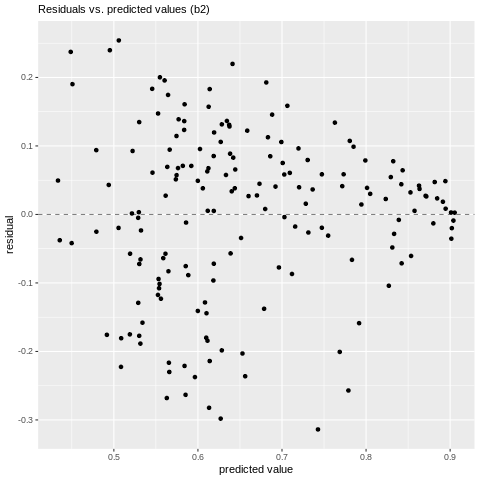

In [ ]:
%%R
# SOURCE: https://avehtari.github.io/ROS-Examples/Introclass/residual_plots.html
tibble(predicted2 = predicted2[,"Estimate"], resid2 = resid2) %>%

  ggplot(aes(x = predicted2, y = resid2)) +
    geom_point() +
    geom_hline(yintercept = 0, linetype = 2, color = "black", alpha = 1/2) +
    labs(subtitle = "Residuals vs. predicted values (b2)",
        y = "residual",
        x = "predicted value")

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
log_model_df <- data.frame(x = log(EconomistData$CPI), 
                           y = predict(b2)[,"Estimate"])
head(log_model_df)

          x         y
1 0.4054651 0.4313802
2 1.1314021 0.6231986
3 1.0647107 0.6015939
4 0.6931472 0.5086171
5 1.0986123 0.6079840
6 0.9555114 0.5758654


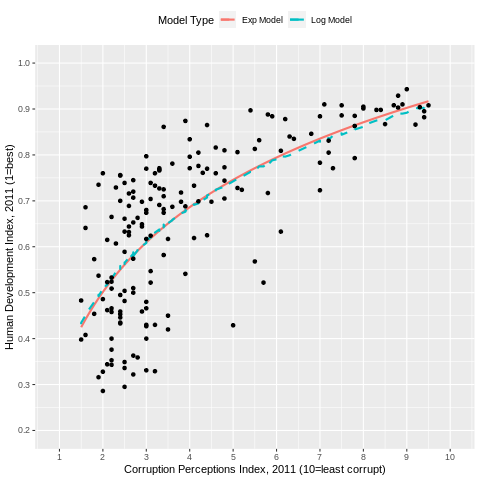

In [ ]:
%%R
EconomistData %>%
  ggplot(aes(x = CPI, y = HDI)) +
  geom_smooth(method = "lm", aes(colour = "Exp Model"), formula = y ~ log(x), se = FALSE, linetype = 1) +
  geom_line(data = log_model_df, aes(exp(x), y, colour = "Log Model"), size = 1, linetype = 2) + 
  geom_point() +
  scale_x_continuous(name = "Corruption Perceptions Index, 2011 (10=least corrupt)",
                     breaks = 1:1:10,
                     limits = c(0.9,10.1)) +
  scale_y_continuous(name = "Human Development Index, 2011 (1=best)",
                     limits = c(0.2, 1.0),
                     breaks = seq(0.2, 1.0, by = 0.1)) +
  guides(color = guide_legend("Model Type")) +
  theme(legend.position = "top",
        legend.direction = "horizontal")

## Model comparison

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/ulysses-compass.html#model-mis-selection.
w <- loo_compare(b1, b2, criterion = "waic") %>% 
  
print(w, simplify = F)

   elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic   se_waic
b2    0.0       0.0   116.8       8.7          2.5    0.3    -233.7   17.3 
b1   -4.1       2.7   112.7       7.6          2.2    0.2    -225.4   15.2 


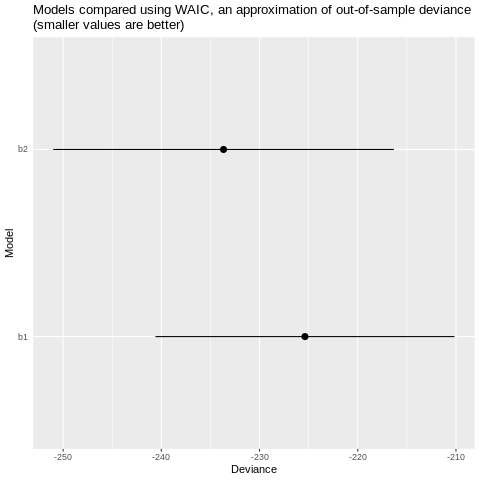

In [ ]:
%%R
# WAIC comparison plot
w[, 7:8] %>% 
  data.frame() %>% 
  rownames_to_column("model_name") %>% 
  mutate(model_name = fct_reorder(model_name, waic, .desc = T)) %>% 
  
  ggplot(aes(x = waic, y = model_name, 
             xmin = waic - se_waic, 
             xmax = waic + se_waic)) +
  geom_pointrange() +
  labs(title = "Models compared using WAIC, an approximation of out-of-sample deviance\n(smaller values are better)",
       x = "Deviance", y = "Model") +
  theme(axis.ticks.y = element_blank())

## Plots to communicate and explain

### Compute the model's $R^2$ to display in the plot

In [ ]:
%%R
b2_R2 <- round(bayes_R2(b2)[,"Estimate"], 3)
b2_R2

[1] 0.499


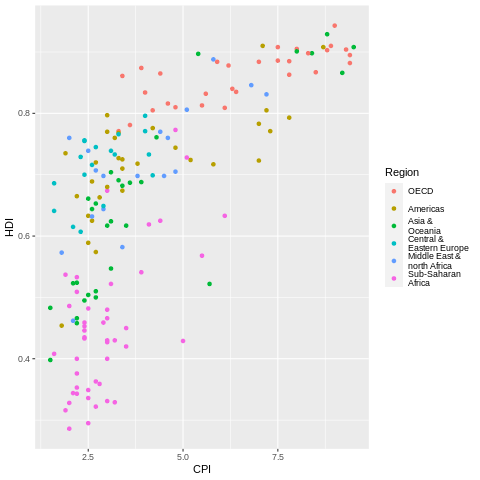

In [ ]:
#@title Initial plot with points colored by region
%%R
# SOURCE: http://rstudio-pubs-static.s3.amazonaws.com/284329_c7e660636fec4a42a09eed968dc47f32.html
g1 <-  ggplot(EconomistData, aes(x = CPI, y = HDI))

g1 + geom_point(aes(color = Region))

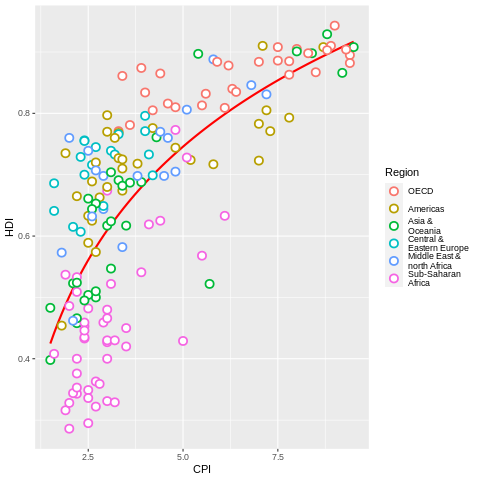

In [ ]:
#@title Change the points' attributes and add the fitted line
%%R
g2 <- g1 + 
  geom_smooth(aes(group = 1),
              method = "lm",
              formula = y ~ log(x),
              se = FALSE,
              color = "red") +
  geom_point(aes(color = Region), 
             shape = 21, 
             fill = "White", 
             size = 3, 
             stroke = 1.25)
g2

### Add country labels to points identified (called out) in The Economist article

In [ ]:
%%R
points1 <-  c("Afghanistan", "Sudan", "Myanmar", "Iraq", "Venezuela", 
              "Argentina", "Greece",  "Italy", "United States", "Norway", 
              "New Zealand", "Singapore", "Britain", "Barbados", "Botswana",
              "Cape Verde", "Bhutan", "Rwanda",  "India", "Congo")

points2 <- c("Russia", "Brazil", "Spain", "France", 
             "Germany", "Japan", "China", "South Africa")

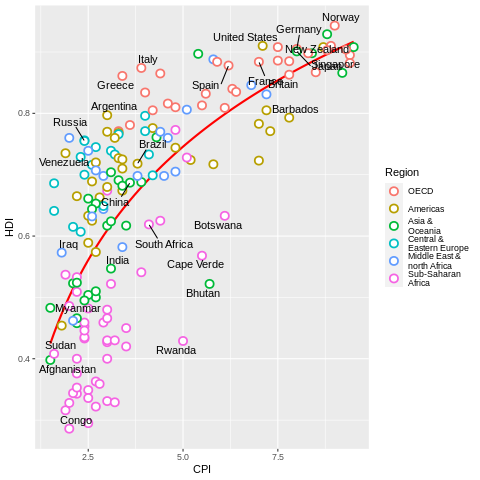

In [ ]:
%%R
g3 <- g2 + 
  geom_text_repel(data = subset(EconomistData, Country %in% points1), 
                  aes(label = Country), 
                  max.overlaps = Inf) +
  geom_text_repel(data = subset(EconomistData, Country %in% points2), 
                  aes(label = Country), 
                  box.padding = unit(1.0, 'lines'), 
                  max.overlaps = Inf)
g3

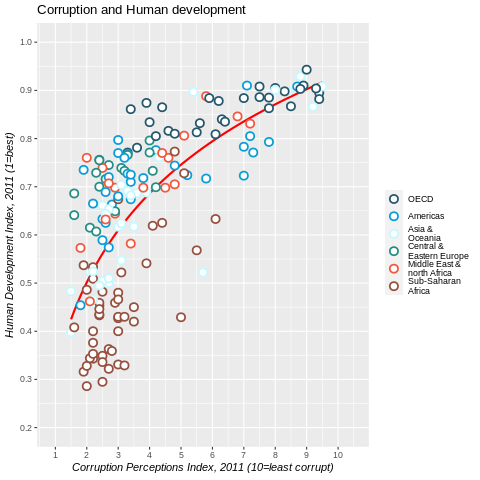

In [ ]:
#@title Change color scheme and add title and labels
%%R
region_colors1 <- c("#24576D", "#099DD7", "#C5F9FF", "#248E84", "#F2583F", "#96503F")

g4 <- g2 + 
  scale_x_continuous(name = expression(italic("Corruption Perceptions Index, 2011 (10=least corrupt)")),
                     limits = c(.9, 10.5),
                     breaks = 1:10) +
  scale_y_continuous(name = expression(italic("Human Development Index, 2011 (1=best)")),
                     limits = c(0.2, 1.0),
                     breaks = seq(0.2, 1.0, by = 0.1)) +
  scale_color_manual(name = "",
                     values = region_colors1) +
  ggtitle("Corruption and Human development")
g4

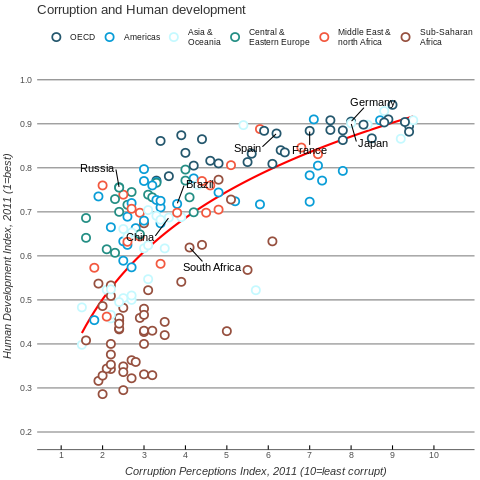

In [ ]:
#@title Reposition the legend and customize the grid lines and tick marks to match those in The Economist article
%%R
g4 + 
  theme_minimal() + # start with a minimal theme and add what we need
  theme(text = element_text(color = "gray20"),
        legend.position = "top", # position the legend in the upper left 
        legend.direction = "horizontal",
        legend.justification = c(0.1,0), # anchor point for legend.position.
        legend.text = element_text(size = 8.5, color = "gray10"),
        #axis.text = element_text(face = "italic"),
        axis.title.x = element_text(vjust = -1), # move title away from axis
        axis.title.y = element_text(vjust = 2), # move away for axis
        axis.ticks.y = element_blank(), # element_blank() is how we remove elements
        axis.ticks.x = element_line(),
        axis.ticks.length.x = unit(-0.15, "cm"),
        axis.line = element_line(color = "gray40", size = 0.5),
        axis.line.y = element_blank(),
        panel.grid.major.y = element_line(color = "gray50", size = 0.5),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
        ) + 
  guides(colour = guide_legend(nrow = 1)) + # forces legend to be in a single line 
  #geom_text_repel(data = subset(EconomistData, Country %in% points1), 
  #                aes(label = Country), 
  #                max.overlaps = Inf) +
  geom_text_repel(data = subset(EconomistData, Country %in% points2), 
                  aes(label = Country), 
                  box.padding = unit(1.0, 'lines'), 
                  max.overlaps = Inf)